# 1. Problem Statement: Sensor Fault Detection (APS)

### Context
The system in focus is the **Air Pressure System (APS)**, which generates pressurized air for critical truck functions such as braking and gear changes. 

### Objective
The goal is to predict failures in the APS system to minimize maintenance costs.
* **Positive Class (+):** Component failures related specifically to the APS.
* **Negative Class (-):** Failures related to other truck components (non-APS).

---

### Cost Evaluation Matrix
To minimize unnecessary repair costs, we must evaluate the model based on the following financial implications:

| Predicted \ True | Positive (Actual Failure) | Negative (No APS Failure) |
| :--- | :--- | :--- |
| **Positive (Predict Failure)** | Correct Diagnosis | **Cost 1 (Type I Error)** |
| **Negative (Predict No Failure)** | **Cost 2 (Type II Error)** | Correct Diagnosis |

#### Cost Breakdown:
* **Cost 1 (False Positive):** $10$ 
  * *Description:* Unnecessary check by a mechanic at a workshop.
* **Cost 2 (False Negative):** $500$ 
  * *Description:* Missing a faulty truck, leading to a potential breakdown.

**Total Cost Formula:**
$$Total\_Cost = (10 \times \text{False Positives}) + (500 \times \text{False Negatives})$$

> **Key Priority:** While we aim to reduce both errors, reducing **False Negatives** is the primary objective, as the cost of a breakdown is **50 times higher** than an unnecessary workshop visit.

---

### Challenges & Requirements
* **Data Quality:** Significant number of missing (Null) values across almost all columns.
* **Latency:** No low-latency requirement; accuracy and cost-savings are prioritized over speed.
* **Interpretability:** Model interpretability is not a requirement.
* **Impact:** High financial sensitivity to misclassification.

### Load the lib 

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean
import seaborn as sns
import warnings
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split ,RepeatedStratifiedKFold,cross_val_score
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from catboost import CatBoostClassifier
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
from xgboost import XGBClassifier

## Load the clean dataset

In [4]:
df=pd.read_csv("D:/sensorlive/Notebook/cleaned_dataset.csv")

In [5]:
df

,Unnamed: 0,class,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,pos,153204,1.820000e+02,NaN,0.0,0.0,0.0,0.0,0.0,...,129862.0,26872.0,34044.0,22472.0,34362.0,0.0,0.0,0.0,0.0,0.0
1,1,pos,453236,2.926000e+03,NaN,0.0,0.0,0.0,0.0,222.0,...,7908038.0,3026002.0,5025350.0,2025766.0,1160638.0,533834.0,493800.0,6914.0,0.0,0.0
2,2,pos,72504,1.594000e+03,1052.0,0.0,0.0,0.0,244.0,178226.0,...,1432098.0,372252.0,527514.0,358274.0,332818.0,284178.0,3742.0,0.0,0.0,0.0
3,3,pos,762958,NaN,NaN,NaN,NaN,776.0,281128.0,2186308.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,pos,695994,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,1397742.0,495544.0,361646.0,28610.0,5130.0,212.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36183,36183,neg,153002,6.640000e+02,186.0,0.0,0.0,0.0,0.0,0.0,...,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0
36184,36184,neg,2286,2.130707e+09,224.0,0.0,0.0,0.0,0.0,0.0,...,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0
36185,36185,neg,112,2.130706e+09,18.0,0.0,0.0,0.0,0.0,0.0,...,792.0,386.0,452.0,144.0,146.0,2622.0,0.0,0.0,0.0,0.0
36186,36186,neg,80292,2.130706e+09,494.0,0.0,0.0,0.0,0.0,0.0,...,699352.0,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0,0.0,0.0


In [11]:
df.drop(columns='Unnamed: 0',inplace=True)

In [12]:
df

,class,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,pos,153204,1.820000e+02,NaN,0.0,0.0,0.0,0.0,0.0,11804.0,...,129862.0,26872.0,34044.0,22472.0,34362.0,0.0,0.0,0.0,0.0,0.0
1,pos,453236,2.926000e+03,NaN,0.0,0.0,0.0,0.0,222.0,323436.0,...,7908038.0,3026002.0,5025350.0,2025766.0,1160638.0,533834.0,493800.0,6914.0,0.0,0.0
2,pos,72504,1.594000e+03,1052.0,0.0,0.0,0.0,244.0,178226.0,1249396.0,...,1432098.0,372252.0,527514.0,358274.0,332818.0,284178.0,3742.0,0.0,0.0,0.0
3,pos,762958,NaN,NaN,NaN,NaN,776.0,281128.0,2186308.0,8123016.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,pos,695994,NaN,NaN,NaN,NaN,0.0,0.0,0.0,55620.0,...,1397742.0,495544.0,361646.0,28610.0,5130.0,212.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36183,neg,153002,6.640000e+02,186.0,0.0,0.0,0.0,0.0,0.0,2564.0,...,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0
36184,neg,2286,2.130707e+09,224.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0
36185,neg,112,2.130706e+09,18.0,0.0,0.0,0.0,0.0,0.0,0.0,...,792.0,386.0,452.0,144.0,146.0,2622.0,0.0,0.0,0.0,0.0
36186,neg,80292,2.130706e+09,494.0,0.0,0.0,0.0,0.0,0.0,0.0,...,699352.0,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0,0.0,0.0


## create a function for model training and evaluation

In [42]:
def evaluate_clf(true,predicted):
    """
    This function takes in true values and predicted values 
    Return: Accuracy ,F1-score , precision ,Rwecall, Roc-auc score
    """
    acc=accuracy_score(true,predicted) # calculated accuracy
    f1=f1_score(true,predicted) # calculated f1 score
    precision=precision_score(true,predicted)# calculated precision score
    recall=recall_score(true,predicted) # calculated recall
    roc_auc=roc_auc_score(true,predicted)# calculate roc
    return acc, f1, precision, recall, roc_auc


### create cost of the model as per data description


In [ ]:
def total_cost(y_true,y_pred):
    """
    This function takes y_true,y_prediction and prints total 
    cost due to misclassification
    """
    tn,fp,fn,tp=confusion_matrix(y_true,y_pred).ravel()
    cost=10*fp+500*fn
    return cost

## create a function which can evaluate models and return a report 

In [ ]:
def evaluate_models(X, y, models):
    '''
    This function takes in x and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    cost_list = []
    models_list = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1, model_train_precision, \
        model_train_recall, model_train_rocauc_score = evaluate_clf(y_train, y_train_pred)
        train_cost = total_cost(y_train, y_train_pred)

        # Test set performance
        model_test_accuracy, model_test_f1, model_test_precision, \
        model_test_recall, model_test_rocauc_score = evaluate_clf(y_test, y_test_pred)
        test_cost = total_cost(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
        print(f'- COST: {train_cost}.')

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        print(f'- COST: {test_cost}.')
        
        cost_list.append(test_cost)
        print('='*35)
        print('\n')
        
    report = pd.DataFrame(list(zip(models_list, cost_list)), columns=['Model Name', 'Cost']).sort_values(by=["Cost"])
        
    return report

### plot distribution of all independent Numerical variables

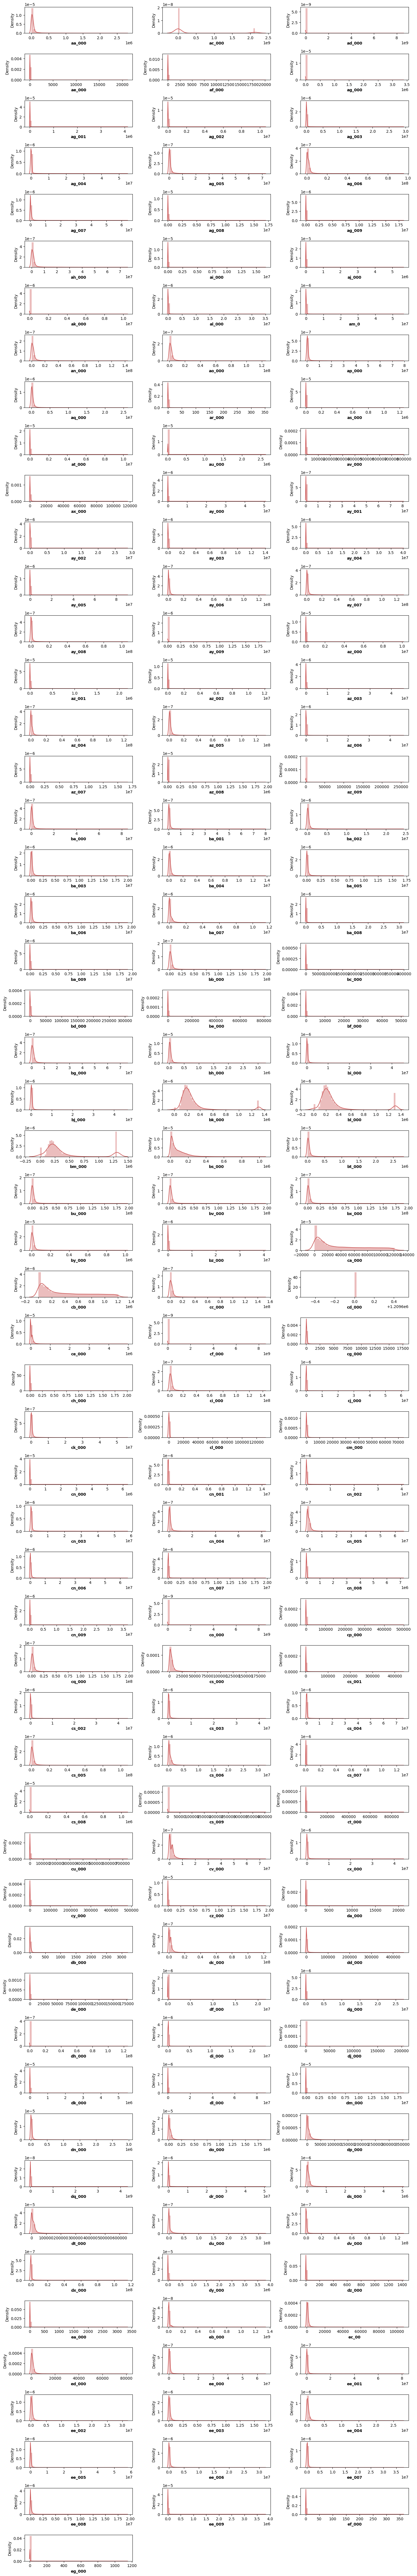

In [19]:
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']

plt.figure(figsize=(15, 100))
for i, col in enumerate(numeric_features):
    plt.subplot(60, 3, i+1)
    sns.distplot(x=df[col], color='indianred')
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

## Report

* As per the above plot most of the features are not normally distributed.
* Transformation of data is not of prime importance since it is a classification problem.
* Interpreting each and every column is not necessary as this is sensor data.

## Evaluate model in Different experiments

In [20]:
## spliting x and y for all experiments
x=df.drop(columns='class',axis=1)
y=df['class']

### Manually Encoding Target variable

In [21]:
y=y.replace({'pos':1,'neg':0})

In [22]:
## print the y that is the numeric target columns
y

0        1
1        1
2        1
3        1
4        1
        ..
36183    0
36184    0
36185    0
36186    0
36187    0
Name: class, Length: 36188, dtype: int64

In [26]:
# check the y contain null or not
y.isnull().sum()

np.int64(0)

# Experiment :1

## KNN imputer for NULL values

### Why Robust scaler and not Standard scaler?

* Scaling the data using Robust scaler
* Since most of the independent variables are not normally distributed we cannot use Standardscaler

### Why Robust Scaler and not Minmax?

* Because most of the feature has outliers. So Minmax will scale data according to Max values which is outlier.
* This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

In [27]:
# fit with robust scaller for  KNN best K-selection experminet
robustescaler=RobustScaler()
x1=robustescaler.fit_transform(x)

### Why KNN Imputer?

* KNNImputer by scikit-learn is a widely used method to impute missing values. It is widely being observed as a replacement for traditional imputation techniques.
* KNNImputer helps to impute missing values present in the observations by finding the nearest neighbors with the Euclidean distance matrix.
* Here we Iterates through different K values and get accuracy and choose best K values.

### Find the optiman n_neighbour values for KNN imputer

In [31]:
results=[]
# define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
strategies = [str(i) for i in [1,3,5,7,9]]
for s in strategies:
    pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', LogisticRegression())])
    scores = cross_val_score(pipeline, x1, y, scoring='accuracy', cv=2, n_jobs=-1)
    results.append(scores)
    print('n_neighbors= %s || accuracy (%.4f)' % (s , mean(scores)))

n_neighbors= 1 || accuracy (0.7152)
n_neighbors= 3 || accuracy (0.7157)
n_neighbors= 5 || accuracy (0.7287)
n_neighbors= 7 || accuracy (0.6788)
n_neighbors= 9 || accuracy (0.7056)


### we can observe n_neighbors=5 able to produce highest accuracy

### pipeline for KNN imputer


In [34]:
num_features = x.select_dtypes(exclude="object").columns

# Fit the KNN imputer with selected K-value
knn_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('RobustScaler', RobustScaler())
])

In [35]:

x_knn =knn_pipeline.fit_transform(x)

## Handling Imbalanced data

**SMOTE+TOME** is one of such a hybrid technique that aims to clean overlapping data points for each of the classes distributed in sample space.

* This method combines the SMOTE ability to generate synthetic data for minority class and Tomek Links ability to remove the data that are identified as Tomek links from the majority class

* To add new data of minority class

1. Choose random data from the minority class.
2. Calculate the distance between the random data and its k nearest neighbors.
3. Multiply the difference with a random number between 0 and 1, then add the result to the minority class as a synthetic sample.
4. Repeat step number 2–3 until the desired proportion of minority class is met.

* To remove the tomek links of the majority class
1. Choose random data from the majority class.
2. If the random data’s nearest neighbor is the data from the minority class (i.e. create the Tomek Link), then remove the Tomek Link.
* This is method instead of adding duplicate data it synthesises the new data based on the already avalialble classes. Hence we choose this as our imputer method for this problem.

In [37]:
from imblearn.combine import SMOTETomek

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority',n_jobs=-1)
# Fit the model to generate the data.
x_res, y_res = smt.fit_resample(x_knn, y)

## Initialize Default Models in a dictionary

In [ ]:
# Dictionary which contains models for experiment
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
    "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier()
}

### Fit KNN imputer data for models in directonary

In [50]:
report_knn=evaluate_models(x_res,y_res,models)

KeyboardInterrupt: 

### Report for KNN imputed data

In [45]:
report_knn

,Model Name,Cost
5,XGBClassifier,5350
6,CatBoosting Classifier,8520
0,Random Forest,14700
1,Decision Tree,38710
4,K-Neighbors Classifier,47800
2,Gradient Boosting,50470
7,AdaBoost Classifier,100150
3,Logistic Regression,268930


## Insights

* For the Experiment 1: Knn imputer has XGBoost classifier as the best Model
* Proceeding with further experiments

# Experiment: 2

## Simple Imputer with Strategy Median

* SimpleImputer is a class in the sklearn.impute module that can be used to replace missing values in a dataset, using a variety of input strategies.
* Here we use SimpleImputer can also be used to impute multiple columns at once by passing in a list of column names. SimpleImputer will then replace missing values in all of the specified columns.

In [ ]:
num_features = x.select_dtypes(exclude="object").columns

# Fit the Simple imputer with strategy median
median_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('RobustScaler', RobustScaler())
])

In [47]:
# Fit X with median_pipeline
x_median = median_pipeline.fit_transform(x)

In [48]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority')
# Fit the model to generate the data.
x_res, y_res = smt.fit_resample(x_median, y)

In [49]:
# Training the models
report_median = evaluate_models(x_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9917
- F1 score: 0.9918
- Precision: 0.9867
- Recall: 0.9970
- Roc Auc Score: 0.9917
- COST: 11450.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9856
- F1 score: 0.9858
- Precision: 0.9803
- Recall: 0.9914
- Roc Auc Score: 0.9855
- COST: 31910.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9840
- F1 score: 0.9840
- Precision: 0.9813
- Recall: 0.9867
- Roc Auc Score: 0.9840
- COST: 190760.
----------------------------------
Model performance for Test set
- Accuracy: 0.9809
- F1 score: 0.9812
- Precision: 0.9755
- Recall: 0.9868
- Roc Auc

## Report for Simple Imputer with median strategy

In [51]:
report_median

,Model Name,Cost
6,CatBoosting Classifier,6310
5,XGBClassifier,6570
0,Random Forest,11450
1,Decision Tree,31910
2,Gradient Boosting,48250
4,K-Neighbors Classifier,54430
7,AdaBoost Classifier,89540
3,Logistic Regression,323640


### Insights

* For the Experiment 2: Simple imputer with median strategy has Catboost classifier as the best Model
* Proceeding with further experiments

# Experiment NO: 3

## MICE for imputing Null values

* MICE stands for Multivariate Imputation By Chained Equations algorithm
* This technique by which we can effortlessly impute missing values in a dataset by looking at data from other columns and trying to estimate the best prediction for each missing value.

* **ImputationKernel** Creates a kernel dataset. This dataset can perform MICE on itself, and impute new data from models obtained during MICE.

In [56]:
import miceforest as mf

x_mice = x.copy()

kernel = mf.ImputationKernel(
    x_mice,
    random_state=1989
)
kernel.mice(3, save_all_iterations=True)

In [57]:
x_mice = kernel.complete_data()

In [58]:
# fit robust scaler
mice_pipeline = Pipeline(steps=[
    ('RobustScaler', RobustScaler())
])

In [59]:
# Fit X with Mice imputer 
x_mice= mice_pipeline.fit_transform(x_mice)

In [60]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1 )
# Fit the model to generate the data.
x_res, y_res = smt.fit_resample(x_mice, y)

In [61]:
# Training the models
report_mice = evaluate_models(x_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9919
- F1 score: 0.9919
- Precision: 0.9872
- Recall: 0.9966
- Roc Auc Score: 0.9919
- COST: 12900.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9841
- F1 score: 0.9841
- Precision: 0.9797
- Recall: 0.9885
- Roc Auc Score: 0.9841
- COST: 41430.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9833
- F1 score: 0.9834
- Precision: 0.9794
- Recall: 0.9875
- Roc Auc Score: 0.9833
- COST: 181830.
----------------------------------
Model performance for Test set
- Accuracy: 0.9828
- F1 score: 0.9828
- Precision: 0.9786
- Recall: 0.9871
- Roc Auc

### Report for MICE imputer algorithm

In [62]:
report_mice

,Model Name,Cost
5,XGBClassifier,3410
6,CatBoosting Classifier,6110
0,Random Forest,12900
1,Decision Tree,41430
2,Gradient Boosting,46510
4,K-Neighbors Classifier,55950
7,AdaBoost Classifier,85220
3,Logistic Regression,149650


## Insights

* For the Experiment 3: Mice imputer has XGBoost classifier as the best Model
* Proceeding with further experiments

# Experiment 4:

## simpel imputer with strategy constant

* Another strategy which can be used is replacing missing values with a fixed (constant) value.
* To do this, specify “constant” for strategy and specify the fill value using the fill_value parameter


In [63]:
# Create a pipeline with simple imputer with strategy constant and fill value 0
constant_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('RobustScaler', RobustScaler())
])

In [65]:
x_const =constant_pipeline.fit_transform(x)

In [66]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1 )
# Fit the model to generate the data.
x_res, y_res = smt.fit_resample(x_const, y)

In [67]:
# training the models
report_const = evaluate_models(x_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9930
- F1 score: 0.9931
- Precision: 0.9891
- Recall: 0.9970
- Roc Auc Score: 0.9930
- COST: 11270.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9867
- F1 score: 0.9869
- Precision: 0.9810
- Recall: 0.9927
- Roc Auc Score: 0.9867
- COST: 26850.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9827
- F1 score: 0.9827
- Precision: 0.9797
- Recall: 0.9857
- Roc Auc Score: 0.9827
- COST: 205730.
----------------------------------
Model performance for Test set
- Accuracy: 0.9809
- F1 score: 0.9810
- Precision: 0.9774
- Recall: 0.9846
- Roc Auc

## Report for simple imputer with constant strategy

In [68]:
report_const

,Model Name,Cost
5,XGBClassifier,2890
6,CatBoosting Classifier,4480
0,Random Forest,11270
1,Decision Tree,26850
4,K-Neighbors Classifier,43200
2,Gradient Boosting,55600
7,AdaBoost Classifier,92210
3,Logistic Regression,115550


## Insights

* For the Experiment 4: Simple imputer with constant strategy has XGBoost classifier as the best Model
* Proceeding with further experiments

# Experiment: 5

### Simple Imputer with Strategy Mean

* Another strategy which can be used is replacing missing values with mean
* Here we replace the missing values with the mean of the column


In [69]:
# Create a pipeline with Simple imputer with strategy mean
mean_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='mean')),
    ('RobustScaler', RobustScaler())
])

In [70]:
x_mean = mean_pipeline.fit_transform(x)

In [71]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority' , n_jobs=-1)
# Fit the model to generate the data.
x_res, y_res = smt.fit_resample(x_mean, y)

In [72]:
# Training all models
report_mean = evaluate_models(x_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9938
- F1 score: 0.9937
- Precision: 0.9900
- Recall: 0.9975
- Roc Auc Score: 0.9938
- COST: 9200.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9869
- F1 score: 0.9868
- Precision: 0.9839
- Recall: 0.9896
- Roc Auc Score: 0.9869
- COST: 37120.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9856
- F1 score: 0.9857
- Precision: 0.9828
- Recall: 0.9886
- Roc Auc Score: 0.9856
- COST: 164880.
----------------------------------
Model performance for Test set
- Accuracy: 0.9865
- F1 score: 0.9863
- Precision: 0.9835
- Recall: 0.9892
- Roc Auc 

## Report for simple imputer with strategy mean 

In [73]:
report_mean

,Model Name,Cost
5,XGBClassifier,2380
6,CatBoosting Classifier,6460
0,Random Forest,9200
1,Decision Tree,37120
2,Gradient Boosting,38650
4,K-Neighbors Classifier,44770
7,AdaBoost Classifier,91120
3,Logistic Regression,303910


## Experiment: 6

### Principle component analysis with imputing median

* Principal component analysis is a technique for feature extraction — so it combines our input variables in a specific way, then we can drop the “least important” variables while still retaining the most valuable parts of all of the variables!
* As the dataset has 164 columns we can try PCA and check our metrics Cost

In [74]:
from sklearn.decomposition import PCA

In [75]:
pca_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('RobustScaler', RobustScaler())
])

In [76]:
x_pca = pca_pipeline.fit_transform(x)

In [78]:
#Applying PCA
from sklearn.decomposition import PCA
var_ratio={}
for n in range(2,150):
    pc=PCA(n_components=n)
    df_pca=pc.fit(x_pca)
    var_ratio[n]=sum(df_pca.explained_variance_ratio_)

### Variance Plot

<Axes: >

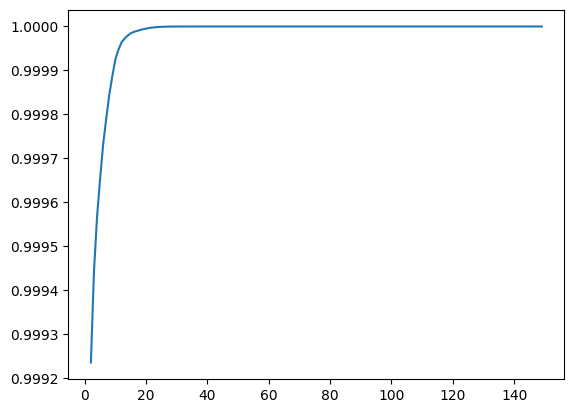

In [79]:
# plotting variance ratio
pd.Series(var_ratio).plot()

## Kneed algorithm to find the elbow point

<Figure size 500x500 with 0 Axes>

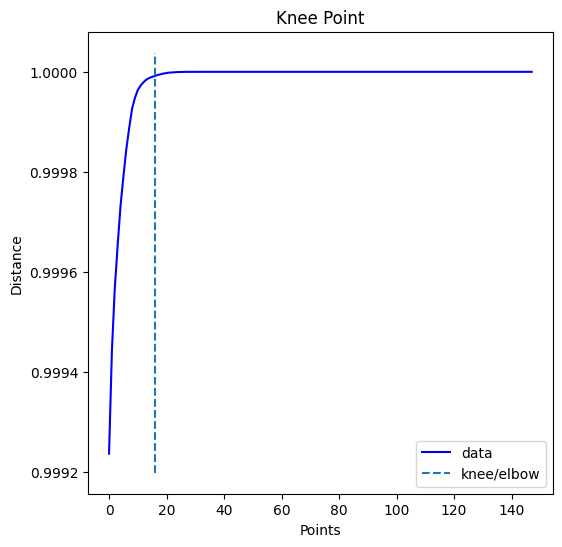

Knee Locator k = 18


In [80]:
from kneed import KneeLocator

i = np.arange(len(var_ratio))
variance_ratio= list(var_ratio.values())
components=  list(var_ratio.keys())
knee = KneeLocator(i, variance_ratio, S=1, curve='concave', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()
k= components[knee.knee]
print('Knee Locator k =', k)

In [81]:
# Reducing the dimensions of the data 
pca_final=PCA(n_components=18,random_state=42).fit(x_res)

reduced=pca_final.fit_transform(x_pca)


In [82]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1)
# Fit the model to generate the data.
x_res, y_res = smt.fit_resample(reduced, y)

In [83]:
# Training all models
report_pca = evaluate_models(x_res,y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 0.9988
- F1 score: 0.9988
- Precision: 1.0000
- Recall: 0.9976
- Roc Auc Score: 0.9988
- COST: 33000.
----------------------------------
Model performance for Test set
- Accuracy: 0.9825
- F1 score: 0.9827
- Precision: 0.9776
- Recall: 0.9879
- Roc Auc Score: 0.9824
- COST: 44100.


Decision Tree
Model performance for Training set
- Accuracy: 0.9988
- F1 score: 0.9988
- Precision: 1.0000
- Recall: 0.9976
- Roc Auc Score: 0.9988
- COST: 33000.
----------------------------------
Model performance for Test set
- Accuracy: 0.9706
- F1 score: 0.9710
- Precision: 0.9663
- Recall: 0.9758
- Roc Auc Score: 0.9706
- COST: 87900.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9423
- F1 score: 0.9420
- Precision: 0.9450
- Recall: 0.9389
- Roc Auc Score: 0.9423
- COST: 867250.
----------------------------------
Model performance for Test set
- Accuracy: 0.9377
- F1 score: 0.9382
- Precision: 0.9394
- Recall: 0.9369
-

## Report for PCA and Mean imputed data

In [84]:
report_pca

,Model Name,Cost
0,Random Forest,44100
5,XGBClassifier,63470
6,CatBoosting Classifier,77240
4,K-Neighbors Classifier,87010
1,Decision Tree,87900
2,Gradient Boosting,226760
7,AdaBoost Classifier,338780
3,Logistic Regression,696930


## Final Model

In [95]:
from prettytable import PrettyTable

pt=PrettyTable()
pt.field_names=["Model","Imputation_method","Total_cost"]
pt.add_row(["XGBClassifier","Simple Imputer-Constant","2380"])
pt.add_row(["XGBClassifier","Mice","3510"])
pt.add_row(["XGBClassifier","Knn-Imputer","4460"])
pt.add_row(["XGBClassifier","Simple Imputer-Mean","4950"])
pt.add_row(["CatBoostClassifier","Median","5760"])
pt.add_row(["Random Forest","PCA","34150"])
print(pt)

+--------------------+-------------------------+------------+
|       Model        |    Imputation_method    | Total_cost |
+--------------------+-------------------------+------------+
|   XGBClassifier    | Simple Imputer-Constant |    2380    |
|   XGBClassifier    |           Mice          |    3510    |
|   XGBClassifier    |       Knn-Imputer       |    4460    |
|   XGBClassifier    |   Simple Imputer-Mean   |    4950    |
| CatBoostClassifier |          Median         |    5760    |
|   Random Forest    |           PCA           |   34150    |
+--------------------+-------------------------+------------+


## Report

* From the final report we can see than XGBClassifier with Simple imputer with strategy constant has performed the best with cost of 2950

## Fitting the Final model and get reports

In [87]:
final_model = XGBClassifier()

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1)
# Fit the model to generate the data.
x_res, y_res = smt.fit_resample(x_const, y)

In [88]:
x_train, x_test, y_train, y_test = train_test_split(x_res,y_res,test_size=0.2,random_state=42)

final_model = final_model.fit(x_train, y_train)
y_pred = final_model.predict(x_test)

In [89]:
print("Final XGBoost Classifier Accuracy Score (Train) :", final_model.score(x_train,y_train))
print("Final XGBoost Classifier Accuracy Score (Test) :", accuracy_score(y_pred,y_test))

Final XGBoost Classifier Accuracy Score (Train) : 0.9999821759589335
Final XGBoost Classifier Accuracy Score (Test) : 0.9968629687722801


In [90]:
print("Final XGBoost Classifier Cost Metric(Test) :",total_cost(y_test, y_pred))

Final XGBoost Classifier Cost Metric(Test) : 2890


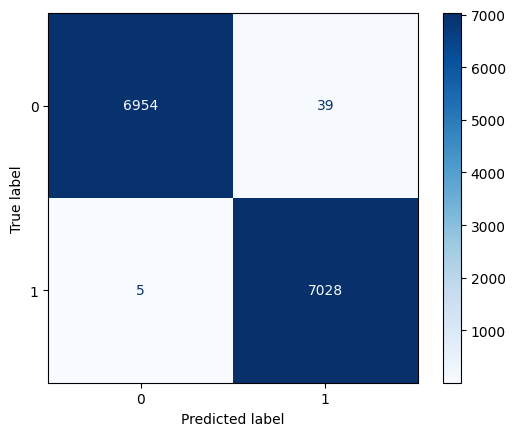

In [94]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Pehle predictions nikal lijiye
y_pred = final_model.predict(x_test)

# 2. Ab 'from_predictions' ka use karein (ye hamesha kaam karega)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', values_format='d')
plt.show()

## The best Model is XGBoost Classifier with 99.6% accuracy and cost of 2380

model building down